In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

## scale data

In [24]:
seq_len = 128
input_size = 6
train_size = 450
test_size = 100
test_minisize = 50
output_size = 2
hidden_size_1 = 50
hidden_size_2 = 70
epoch_num = 200
batch = 16
learning_rate = 0.01

In [25]:
f = open("./Dataset/myData/Kikuzo0701.csv")
f_o = open("./Dataset/myData/kikuzo0701_out.csv", "w")

line = f.readline()
while line:
    f_o.writelines([line[:-7], "\n"])
    line = f.readline()

f.close()
f_o.close()

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path = "./Dataset/myData/"
mmscaler = MinMaxScaler(feature_range=(-1, 1), copy=True)

#training set
amaya_data = np.loadtxt(path + "amaya0701_out.csv", delimiter=",", skiprows=100)
kikuzo_data = np.loadtxt(path + "kikuzo0701_out.csv", delimiter=",", skiprows=100)
rinto_data = np.loadtxt(path + "rinto0701_out.csv", delimiter=",", skiprows=100)

amaya_data = amaya_data[:,1:7]
kikuzo_data = kikuzo_data[:,1:7]
rinto_data = rinto_data[:,1:7]
print(amaya_data.shape)
print(kikuzo_data.shape)
print(rinto_data.shape)

# train_t = np.loadtxt(path + "train/y_train.txt").astype(int)
# train_s = np.loadtxt(path + "train/subject_train.txt").astype(int)

# #test set
# test_ax = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/total_acc_x_test.txt"))
# test_ay = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/total_acc_y_test.txt"))
# test_az = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/total_acc_z_test.txt"))

# test_t = np.loadtxt(path + "test/y_test.txt").astype(int)
# test_s = np.loadtxt(path + "test/subject_test.txt").astype(int)

kikuzo = np.ones((int(len(kikuzo_data)/seq_len), seq_len, input_size), float)
amaya = np.ones((int(len(amaya_data)/seq_len), seq_len, input_size), float)
rinto = np.ones((int(len(rinto_data)/seq_len), seq_len, input_size), float)

for i in range(int(len(kikuzo_data)/seq_len)):
    kikuzo[i,:,:] = kikuzo_data[i*seq_len:(i+1)*seq_len,:]
for i in range(int(len(amaya_data)/seq_len)):
    amaya[i,:,:] = amaya_data[i*seq_len:(i+1)*seq_len,:]
for i in range(int(len(rinto_data)/seq_len)):
    rinto[i,:,:] = rinto_data[i*seq_len:(i+1)*seq_len,:]
    
print(kikuzo.shape)
print(amaya.shape)
print(rinto.shape)



(58634, 6)
(65271, 6)
(65246, 6)
(509, 128, 6)
(458, 128, 6)
(509, 128, 6)


In [27]:
trX = rinto[:train_size]
print(trX.shape)
#amaya_test = amaya[:50]
rinto_test = rinto[450:500]
kikuzo_test = kikuzo[:50]

teX = np.vstack([rinto_test, kikuzo_test])
print(teX.shape)

trY = np.zeros(train_size, int)
print(trY.shape)

teY = np.zeros(test_size, int)
teY[50:100] = np.ones(50,int)
#teY[100:150] = np.ones(50, int) + 1
print(teY.shape)

(450, 128, 6)
(100, 128, 6)
(450,)
(100,)


In [28]:
trainX = torch.Tensor(np.array(trX)).to(device)
trainY = torch.Tensor(np.array(trY)).to(device)

testX = torch.Tensor(np.array(teX)).to(device)
testY = torch.Tensor(np.array(teY)).to(device)

print('trainX.shape:{0}'.format(trainX.shape))
print('trainY.shape:{0}'.format(trainY.shape))
print('testX.shape:{0}'.format(testX.shape))
print('testY.shape:{0}'.format(testY.shape))

# trainYをone-hotにするためlongにsuru
trainY = trainY.long()
# one-hotにする 
trainY = F.one_hot(trainY, num_classes=output_size)
# 誤差を計算できるようにfloatに直す
trainY = trainY.float()
# trY one-hotにする
trY = trainY.cpu().data.numpy()

#testY one-hot ni sinai!
print('trainY.shape:{0}'.format(trainY.shape))

print('testY: {0}'.format(testY))

trainX.shape:torch.Size([450, 128, 6])
trainY.shape:torch.Size([450])
testX.shape:torch.Size([100, 128, 6])
testY.shape:torch.Size([100])
trainY.shape:torch.Size([450, 2])
testY: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


## Dataset Dataloader

In [29]:
class DataSet:
    def __init__(self):
        self.X = trX.astype(np.float32) # 入力
        self.t = trY # 出力

    def __len__(self):
        return len(self.X) # データ数(10)を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.t[index]

In [30]:
# さっき作ったDataSetクラスのインスタンスを作成
dataset = DataSet()
# datasetをDataLoaderの引数とすることでミニバッチを作成．
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, \
                                         shuffle=True, drop_last=True)

## Model

In [31]:
class MyLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.lstm_1 = nn.LSTM(input_size=6, hidden_size=self.hidden_size_1, num_layers=1, batch_first=True) 
        self.lstm_2 = nn.LSTM(input_size=self.hidden_size_1, hidden_size=self.hidden_size_2, \
                              num_layers=1, batch_first=True) 
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.hidden_size_2, output_size)
        #self.softmax = nn.Softmax(-1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size_1).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size_1).to(device)
        h_1 = torch.zeros(1, x.size(0), self.hidden_size_2).to(device)
        c_1 = torch.zeros(1, x.size(0), self.hidden_size_2).to(device)
        out, (h_out, c_out) = self.lstm_1(x, (h_0, c_0))
        _, (h_out, _) = self.lstm_2(out, (h_1, c_1))
        h_out = h_out.view(-1, self.hidden_size_2)
        h_out = self.relu(h_out)
        y_hat = self.linear(h_out)
        #y_hat = self.softmax(h_out)
        return y_hat

In [32]:
def train(model, optimizer, X, t):
  model.train()
  y_hat = model(X)
  # print(y_hat.shape)
  # loss = F.mse_loss(y_hat, trainY)
  loss = nn.CrossEntropyLoss()
  output = loss(y_hat, t)
  optimizer.zero_grad()
  output.backward()
  optimizer.step()
  return output.item()

loss = []


def main():
  model = MyLSTM()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  model = model.to(device)
  for epoch in range(epoch_num):
    for X, t in dataloader:
      _loss = train(model, optimizer, X.to(device), t.to(device))
      loss.append(_loss)
    if epoch % 20 == 0:
      print(f"Epoch = {epoch+1}, Loss = {_loss:.5f}")
  return model

In [33]:
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

# create default optimizer for doctests

param_tensor = torch.zeros([1], requires_grad=True)
default_optimizer = torch.optim.SGD([param_tensor], lr=learning_rate)

# create default trainer for doctests
# as handlers could be attached to the trainer,
# each test must define his own trainer using `.. testsetup:`

def get_default_trainer():

    def train_step(engine, batch):
        return batch

    return Engine(train_step)

# create default model for doctests

# default_model = nn.Sequential(OrderedDict([
#     ('base', nn.Linear(4, 2)),
#     ('fc', nn.Linear(2, 1))
# ]))

# manual_seed(666)

In [34]:
def predict(model):
  model.eval()
  train_predict = model(testX)
  print(train_predict.shape)

  #data_predict = train_predict.cpu().data.numpy()
  #testY_plot = testY.cpu().data.numpy()

  
  data_predict = torch.argmax(train_predict, dim=1)
  data_predict = F.one_hot(data_predict, num_classes=output_size)
  
  metric = ConfusionMatrix(num_classes=output_size)
  metric.attach(default_evaluator, 'cm')
  y_true = testY.int()
  y_pred = data_predict
  print(y_true.shape)
  print(y_pred.shape)

  state = default_evaluator.run([[y_pred, y_true]])
  print(state.metrics['cm'])


In [35]:
model = main()

Epoch = 1, Loss = 0.52868
Epoch = 21, Loss = 0.01955
Epoch = 41, Loss = 0.00704
Epoch = 61, Loss = 0.00483
Epoch = 81, Loss = 0.00288
Epoch = 101, Loss = 0.00206
Epoch = 121, Loss = 0.00197
Epoch = 141, Loss = 0.00162
Epoch = 161, Loss = 0.00157
Epoch = 181, Loss = 0.00110


In [36]:
predict(model)

torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
tensor([[50,  0],
        [50,  0]])


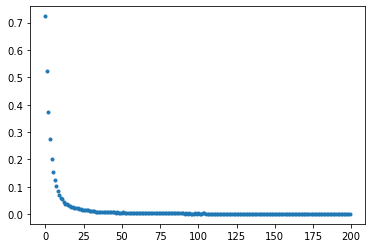

In [37]:
stop = len(loss)
step = int(len(loss) / epoch_num)
plt.plot(loss[0:stop:step], '.', label = "test_error")
plt.show()